[View in Colaboratory](https://colab.research.google.com/github/HUSTneeb/GoogleColabCode/blob/master/TensorFlowLearning10.ipynb)

In [2]:
from __future__ import absolute_import,division,print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print (tf.executing_eagerly())

True


In [3]:
train_dataset_url='http://download.tensorflow.org/data/iris_training.csv'
train_dataset_fp=tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                        origin=train_dataset_url)
print(train_dataset_fp)

8192/2194 [================================================================================================================] - 0s 0us/step
/root/.keras/datasets/iris_training.csv


In [5]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [6]:
column_names=['sepal_length','sepal_width','petal_length','petal_width','species']

feature_names=column_names[:-1]
label_name=column_names[-1]

print(feature_names)
print(label_name)

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
species


In [0]:
class_names=['setosa','versicolor','virginica']

In [0]:
batch_size=32

train_dataset=tf.contrib.data.make_csv_dataset(
  train_dataset_fp,
  batch_size,
  column_names=column_names,
  label_name=label_name,
  num_epochs=1)


In [11]:
features,labels=next(iter(train_dataset))
features

OrderedDict([('sepal_length',
              <tf.Tensor: id=108, shape=(32,), dtype=float32, numpy=
              array([5.4, 5.7, 4.9, 4.7, 5.4, 6.9, 4.5, 4.6, 7.2, 6.4, 5. , 7.7, 5.4,
                     5. , 6.5, 5. , 6.5, 5. , 5. , 6.2, 6.2, 4.4, 5.1, 6.3, 6. , 4.8,
                     4.7, 6. , 5. , 5. , 4.6, 5.7], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=109, shape=(32,), dtype=float32, numpy=
              array([3. , 3. , 3.1, 3.2, 3.4, 3.2, 2.3, 3.2, 3.2, 2.8, 3. , 2.8, 3.7,
                     3.5, 3.2, 2.3, 2.8, 3.4, 3.2, 2.8, 2.2, 2.9, 3.8, 2.5, 2.7, 3.4,
                     3.2, 3. , 2. , 3.5, 3.4, 2.8], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=106, shape=(32,), dtype=float32, numpy=
              array([4.5, 4.2, 1.5, 1.6, 1.5, 5.7, 1.3, 1.4, 6. , 5.6, 1.6, 6.7, 1.5,
                     1.6, 5.1, 3.3, 4.6, 1.5, 1.2, 4.8, 4.5, 1.4, 1.9, 5. , 5.1, 1.6,
                     1.3, 4.8, 3.5, 1.3, 1.4, 4.

Text(0,0.5,'Sepal length')

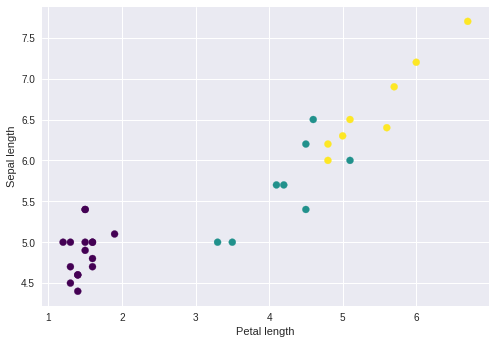

In [12]:
plt.scatter(features['petal_length'],
           features['sepal_length'],
           c=labels,
           cmap='viridis')
plt.xlabel("Petal length")
plt.ylabel('Sepal length')

In [13]:
def pack_features_vector(features,labels):
  features=tf.stack(list(features.values()),axis=1)
  return features,labels
train_dataset=train_dataset.map(pack_features_vector)

features,labels=next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[6.5 3.  5.8 2.2]
 [5.  3.2 1.2 0.2]
 [5.8 2.7 5.1 1.9]
 [5.8 2.6 4.  1.2]
 [7.7 2.8 6.7 2. ]], shape=(5, 4), dtype=float32)


In [0]:
model=tf.keras.Sequential([
    tf.keras.layers.Dense(10,activation=tf.nn.relu,input_shape=(4,)),
    tf.keras.layers.Dense(10,activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])


In [15]:
predictions=model(features)
predictions[:5]

<tf.Tensor: id=255, shape=(5, 3), dtype=float32, numpy=
array([[ 0.03561166,  0.21391368, -3.4287226 ],
       [ 0.45951807,  0.18680882, -2.0883331 ],
       [ 0.03365034,  0.1872369 , -3.052793  ],
       [ 0.06727913,  0.16299808, -2.8741183 ],
       [ 0.00605261,  0.2711463 , -3.8804536 ]], dtype=float32)>

In [18]:
tf.nn.softmax(predictions[:5])
print(tf.argmax(predictions,axis=1))
print(labels)

tf.Tensor([1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0], shape=(32,), dtype=int64)
tf.Tensor([2 0 2 1 2 1 0 0 1 1 2 1 0 0 1 0 1 1 2 2 2 2 0 0 0 2 1 1 2 0 2 0], shape=(32,), dtype=int32)


In [21]:
def loss(model,x,y):
  y_=model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y,logits=y_)

l=loss(model,features,labels)
print(format(l))

1.8859347105026245


In [0]:
def grad(model,inputs,targets):
  with tf.GradientTape() as tape:
    loss_value=loss(model,inputs,targets)
  return loss_value,tape.gradient(loss_value,model.trainable_variables)

In [26]:
optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01)
global_step=tf.train.get_or_create_global_step()

loss_value,grads=grad(model,features,labels)
print((global_step.numpy(),
            loss_value.numpy()))
optimizer.apply_gradients(zip(grads,model.variables),global_step)
print((global_step.numpy(),
            loss(model,features,labels).numpy()))

(1, 1.6057882)
(2, 1.3783455)


In [31]:
train_loss_results=[]
train_accuracy_results=[]

num_epochs=201

for epoch in range(num_epochs):
  epoch_loss_avg=tfe.metrics.Mean()
  epoch_accuracy=tfe.metrics.Accuracy()
  
  for x,y in train_dataset:
    loss_value,grads=grad(model,x,y)
    optimizer.apply_gradients(zip(grads,model.variables),
                             global_step)
    
    epoch_loss_avg(loss_value)
    epoch_accuracy(tf.argmax(model(x),axis=1,output_type=tf.int32),y)
    
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch %50 ==0:
    print(format(epoch),format(epoch_loss_avg.result()),format(epoch_accuracy.result()))

0 3.379836916923523 0.6
50 0.5401478856801987 0.7
100 0.30955399945378304 0.9666666666666667
150 0.19919445738196373 0.975
200 0.14157757349312305 0.9833333333333333


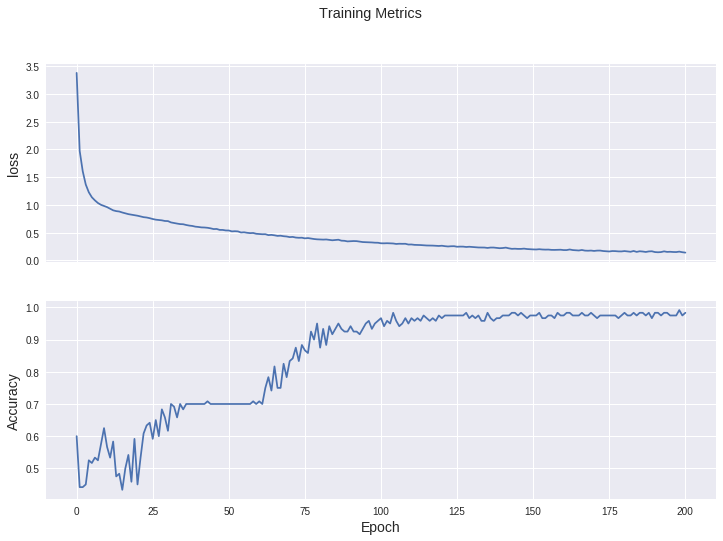

In [44]:
fig,axes=plt.subplots(2,sharex=True,figsize=(12,8))
fig.suptitle("Training Metrics")

axes[0].set_ylabel("loss",fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch",fontsize=14)
axes[1].plot(train_accuracy_results)


In [45]:
test_url="http://download.tensorflow.org/data/iris_test.csv"
test_fp=tf.keras.utils.get_file(fname=os.path.basename(test_url),
                               origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [0]:
test_dataset=tf.contrib.data.make_csv_dataset(
test_fp,
batch_size,
column_names=column_names,
label_name='species',
num_epochs=1,
shuffle=False)

test_dataset=test_dataset.map(pack_features_vector)

In [48]:
test_accuracy=tfe.metrics.Accuracy()

for (x,y) in test_dataset:
  logits=model(x)
  prediction=tf.argmax(logits,axis=1,output_type=tf.int32)
  test_accuracy(prediction,y)
  
print(format(test_accuracy.result()))

0.9333333333333333


In [49]:
predict_dataset=tf.convert_to_tensor([
    [5.1,3.3,1.7,0.5,],
    [5.9,3.0,4.2,1.5,],
    [6.9,3.1,5.4,2.1]
])

predictions=model(predict_dataset)

for i,logits in enumerate(predictions):
  class_idx=tf.argmax(logits).numpy()
  p=tf.nn.softmax(logits)[class_idx]
  name=class_names[class_idx]
  print("Example {} prediction:{}({:4.1f}%)".format(i,name,100*p))

Example 0 prediction:setosa(96.6%)
Example 1 prediction:versicolor(81.3%)
Example 2 prediction:virginica(82.9%)
